In [1]:
import pandas as pd
import pickle
import numpy as np
import boto3
from io import StringIO

# Create S3 session, resource, bucket, and file
s3_session = boto3.Session().client("s3")
s3_resource = boto3.resource("s3")
bucket = 'team-3-project-data'
file = 'district_misdemeanor_felony.csv'

# Read in Courts Mapper
courts_map = pd.read_pickle('courts.pickle')

# Read in Race Mapper File
race_map = pd.read_pickle('race_map.pickle')

# Assign columns which will be used
load_cols = ['FinalDisposition', 
            'SentenceTime', 
            'Complainant', 
            'AmendedCharge', 
            'DefenseAttorney', 
            'Gender', 
            'Race', 
            'CaseType', 
            'Class', 
            'CodeSection',
            'fips']

# Download from S3
## Only need to run once to get the file
# s3_session.download_file(Bucket=bucket, Key=file, Filename=file)

# Read in District Data and drop duplicates
district = pd.read_csv(file, usecols=load_cols)

In [ ]:
district.head()

In [ ]:
# Feature Creation

# Create Public Defender Column
district['PublicDefender'] = district.DefenseAttorney.isin(['Public Defender', 
                                                               'PD', 
                                                               'PUB DEF', 
                                                               'P DEF', 
                                                               'PUBLIC DEFENDER(TSR)', 
                                                               'P/D', 
                                                               'PUBLIC DEFENDER 703-934-5600', 
                                                               'PUBLIC DEFENDER  703-934-5600',
                                                               'PUBLIC DEFENDER 934-5600',
                                                               'PUBLIC DEFENDER (TSR)',
                                                               'PUBLIC DEF',
                                                               'PDEF']+
                                                                [i for i in dict(district.DefenseAttorney.value_counts()) if 'PD' in i]
                                                           )

# Create Column indicating if a charge was amended
district['ChargeAmended'] = district.AmendedCharge.notnull()

# Add in Courts Data from FIPS
district['Court'] = district['fips'].map(courts_map)

In [ ]:
# Clean Data

# Clean Mappings for Race variable
district.Race = district.Race.map(race_map)

# Give Value for NULLs Charge Class
district.Class = district.Class.fillna('None')

# Clean Charge Code Section - Drop NULLs (6 records)
district = district[district['CodeSection'].notnull()]

# Give NUll Sentence Time 0 values - as no sentence would equate to 0
district['SentenceTime'] = district['SentenceTime'].fillna(0).astype(int)

# Drop Records where FinalDisposition is NULL (89854 records)
district = district[district.FinalDisposition.notnull()]

# Drop Records where Complainant is NULL (1 record)
district = district[district.Complainant.notnull()]

In [ ]:
# Subsect Data Frame for only Response and Predictor Variables
usecols = ['FinalDisposition', 'SentenceTime', 'Court', 'Complainant', 'PublicDefender', 'Gender', 'Race', 'CaseType', 'Class', 'CodeSection', 'ChargeAmended']

In [ ]:
# Write Data for Model

# Write Data as CSV to S3 Bucket
with StringIO() as csv_buffer:
    
    # Only get Misdeameanor and Felonies
    district[usecols].to_csv(csv_buffer, index=False)

    # Write file to S3
    response = s3_resource.Object(bucket, 'model_data.csv').put(Body=csv_buffer.getvalue())

    status = response.get("ResponseMetadata", {}).get("HTTPStatusCode")

    # Print whether it was successful
    if status == 200:
        print(f"Successful S3 put_object - response. Status - {status}")
    else:
        print(f"Unsuccessful S3 put_object - response. Status - {status}")

# Data Exploration

In [ ]:
# Read in Data From S3 
model_data = pd.read_csv(s3_session.get_object(Bucket=bucket, Key='redshift-ingestion/model_data.csv')['Body'], low_memory=False)

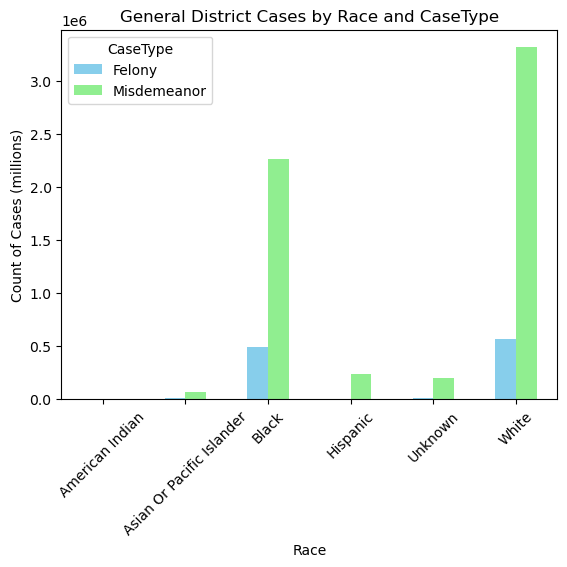

In [38]:
import matplotlib.pyplot as plt

casetype_by_race = model_data.groupby(by=['Race', 'CaseType'])['FinalDisposition'].count().reset_index().sort_values(by=['FinalDisposition'], ascending=False)

pivot_df = casetype_by_race.pivot(index='Race', columns='CaseType', values='FinalDisposition').fillna(0)

pivot_df.plot(kind='bar', color=['skyblue', 'lightgreen'])
plt.xlabel('Race')
plt.ylabel("Count of Cases (millions)")
plt.title('General District Cases by Race and CaseType')
plt.xticks(rotation=45)
plt.legend(title='CaseType')
plt.show()

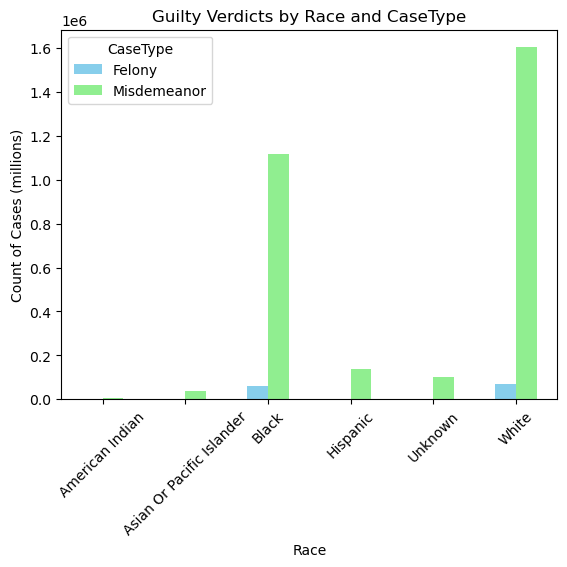

In [39]:
guilty_casetype_by_race = model_data[model_data.FinalDisposition == 'Guilty'].groupby(by=['Race', 'CaseType'])['FinalDisposition'].count().reset_index()

pivot_df = guilty_casetype_by_race.pivot(index='Race', columns='CaseType', values='FinalDisposition').fillna(0)

pivot_df.plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon'])
plt.xlabel('Race')
plt.ylabel("Count of Cases (millions)")
plt.title('Guilty Verdicts by Race and CaseType')
plt.xticks(rotation=45)
plt.legend(title='CaseType')
plt.show()

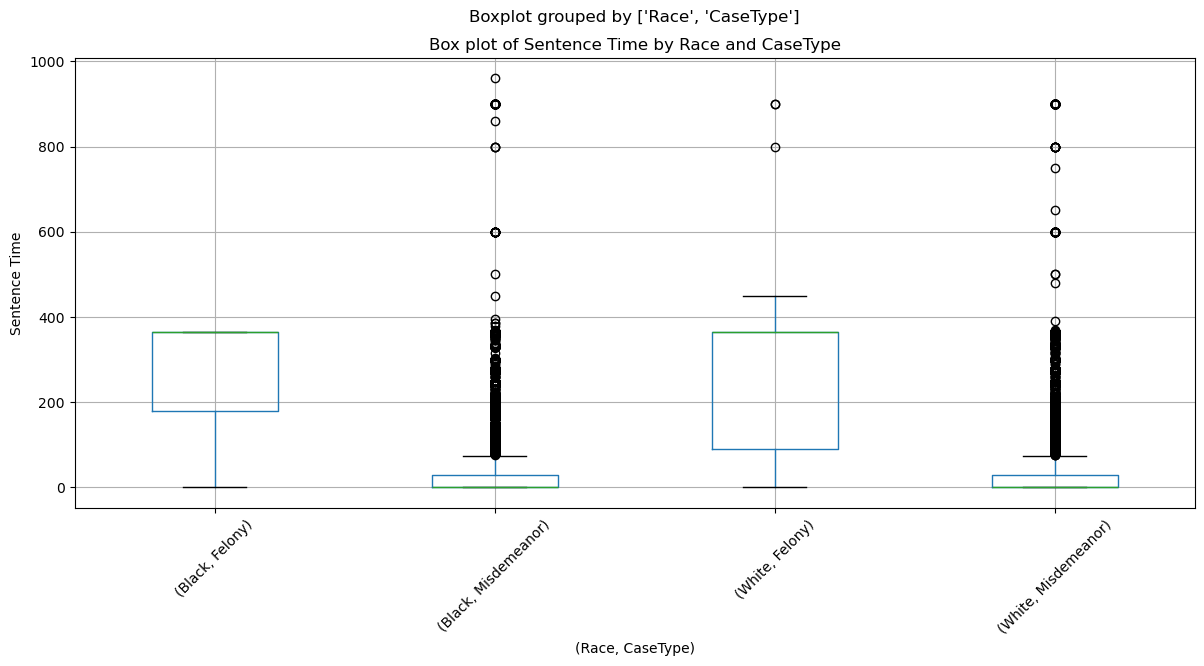

In [42]:
model_data[(model_data.FinalDisposition == 'Guilty')&(model_data.Race.isin(['Black', 'White']))].boxplot(column='SentenceTime', by=['Race', 'CaseType'], figsize=(14,6))
plt.title('Box plot of Sentence Time by Race and CaseType')
plt.xlabel('(Race, CaseType)')
plt.ylabel('Sentence Time')
plt.xticks(rotation=45)
plt.show()